# Analysis of the impact of metro stop location on commuter bikeshare habits
In this notebook I will attempt to answer the following questions using 1 year (~3.25 million rides in 386MB) of Capital Bikeshare data

* how does weekend vs. weekday bike share ridership vary?
* how does bike share ride frequency change throughout the day?
* how does rush hour ridership compare to non-rush hour?
* how do the most popular stations and routes vary between these different time windows?
* how does ride distance vary between these windows?
* can we identify gaps in service by looking at how far a commuter is willing to ride a bike?


In [1]:
import pickle
import pandas as pd
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
import scipy.stats
from geopy.distance import vincenty
import folium
matplotlib.style.use('ggplot')
%matplotlib inline

Load data which has been previous imported and cleaned in other notebooks
* `bike_location` is a dictionary of all Capital Bikeshare stations (key) and their geo-coordinates (value)
* `station_data` is a 2D dictionary of the metro stations (2nd level key) along each line (1st level key) and their geo-coordinates (2nd level values)
* `metro_delays` is a pandas dataframe listing every delay time, affect line, and duration from WMATA 
* `bikeshare_rides` is a pandas dataframe listing every ride for the most recent available year (2015-Q4 through 2016-Q3)

In [2]:
bike_location = pickle.load(open("bike_location.p", "rb"))
station_data = pickle.load(open("station_data.p", "rb"))
metro_delays = pickle.load(open("metro_delays.p", "rb"))
bikeshare_rides = pickle.load(open("bikeshare_rides_all.p", "rb"))

create list of all bike share stations to which I have location data then drop all rides which utilize one of these stations

In [3]:
bikestation_list = []
for key in bike_location:
    bikestation_list.append(key)

In [4]:
print('There are {:.0f} total rides in the data'.format(len(bikeshare_rides)))
bikeshare_rides = bikeshare_rides.where(bikeshare_rides['Start station'].str[:].isin(bikestation_list)).dropna()
bikeshare_rides = bikeshare_rides.where(bikeshare_rides['End station'].str[:].isin(bikestation_list)).dropna()
print('There are {:.0f} rides to which we have location data'.format(len(bikeshare_rides)))

There are 3268722 total rides in the data
There are 3149318 rides to which we have location data


create some columns to help with indexing later

In [5]:
bikeshare_rides['Hour'] = bikeshare_rides.index.hour
bikeshare_rides['Minute'] = bikeshare_rides.index.minute
bikeshare_rides['Day'] = bikeshare_rides.index.weekday_name
bikeshare_rides['Route'] = bikeshare_rides['Start station'] + " to " + bikeshare_rides['End station']
business_days = pd.bdate_range(bikeshare_rides.index.min(), bikeshare_rides.index.max())
weekend_days = len(business_days) / 5 * 2
print('Number of weekend days:    {}'.format(int(weekend_days)))
print('Number of weekday days:    {}'.format(int(len(business_days))))

Number of weekend days:    104
Number of weekday days:    262


Now let's determine which bikeshare stations are within a given distance to ANY metro station.  
Then we can create a flag which indicates if a each bikeshare ride orginates, or terminates, near a metro station (this will be useful later on in our analysis)

Define functions which were initally written and tested in other notebooks

In [6]:
def close_stations(distance):
    """This fn will return a dict of bikeshare stations close 
    to each metro stop based on the suppled distance in miles"""
    lines = ['RD', 'YL', 'GR','BL', 'OR', 'SV']
    bikes_close = dict()
    for ii in range(len(lines)):
        bikes_temp = []
        for key_metro in station_data[lines[ii]]:
            for key_bike in bike_location:
                dist = vincenty(station_data[lines[ii]][key_metro], bike_location[key_bike]).miles
                if dist <= distance:
                    bikes_temp.append(key_bike)
                    #print([lines[ii], key_metro, key_bike, dist])
        bikes_close[lines[ii]] = list(set(bikes_temp))
    return bikes_close


In [7]:
stations_close_dict = close_stations(0.15)

In [8]:
nearby_stations = []
for key in stations_close_dict:
    nearby_stations = nearby_stations + stations_close_dict[key]

nearby_stations = list(set(nearby_stations))
print('This is how many bike share stations are considered "nearby":    {}'.format(str(len(nearby_stations))))
print('This is how many bike share stations are considered "far":    {}'.format(str(len(bike_location))))

This is how many bike share stations are considered "nearby":    86
This is how many bike share stations are considered "far":    441


In [9]:
bikeshare_rides['Start dist'] = np.nan
mask = bikeshare_rides['Start station'].isin(nearby_stations)
bikeshare_rides['Start dist'] = bikeshare_rides['Start dist'].where(~mask, other='near')
bikeshare_rides['Start dist'] = bikeshare_rides['Start dist'].where(mask, other='far')

bikeshare_rides['End dist'] = np.nan
mask = bikeshare_rides['End station'].isin(nearby_stations)
bikeshare_rides['End dist'] = bikeshare_rides['End dist'].where(~mask, other='near')
bikeshare_rides['End dist'] = bikeshare_rides['End dist'].where(mask, other='far')

What is the ratio of Registered vs. Casual riders for all rides during this 1 year period?

In [10]:
bikeshare_rides.groupby("Member Type")['Member Type'].count()

Member Type
Casual         628777
Registered    2520541
Name: Member Type, dtype: int64

In [11]:
print('{:.0f}% of all rides are from Registered riders'.format((bikeshare_rides.groupby("Member Type")['Member Type']
                                                                .count().iloc[1]) / len(bikeshare_rides)*100))

80% of all rides are from Registered riders


Slice bikeshare data to get the following 'windows':
* weekdays
* weekends

In [12]:
bikeshare_weekday = bikeshare_rides[bikeshare_rides['Day'].str[0].isin(list('MTWF'))]
bikeshare_weekend = bikeshare_rides[~bikeshare_rides['Day'].str[0].isin(list('MTWF'))]

In [13]:
print(bikeshare_weekday['Day'].unique())
print(bikeshare_weekend['Day'].unique())
print('Weekday rides:    ', bikeshare_weekday['Start station'].count())
print('Weekend rides:    ', bikeshare_weekend['Start station'].count())
print('{:.0f}% of the rides are during the work week'.format(bikeshare_weekday['Start station'].count() / 
                                                         bikeshare_rides['Start station'].count()*100))

['Thursday' 'Friday' 'Monday' 'Tuesday' 'Wednesday']
['Saturday' 'Sunday']
Weekday rides:     2333344
Weekend rides:     815974
74% of the rides are during the work week


Now that we have the different 'windows' to look at weekday vs weekend 24 hour periods


In [14]:
(bikeshare_weekday.groupby('Hour')['Hour'].count() / len(business_days))

Hour
0       46.160305
1       21.015267
2       10.770992
3        5.179389
4        8.400763
5       71.961832
6      241.030534
7      651.832061
8      969.541985
9      459.221374
10     266.519084
11     308.862595
12     382.763359
13     377.240458
14     352.446565
15     417.874046
16     639.324427
17    1103.553435
18     931.603053
19     606.026718
20     420.648855
21     293.851145
22     203.454198
23     116.610687
Name: Hour, dtype: float64

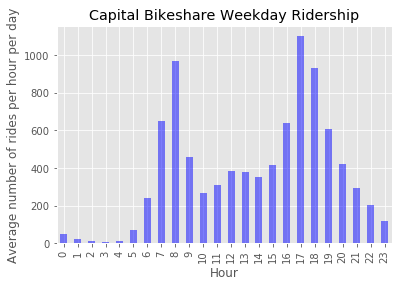

In [15]:
fig, ax = plt.subplots(figsize=[6, 4])
ax.set_ylabel('Average number of rides per hour per day')
ax.set_title('Capital Bikeshare Weekday Ridership')
(bikeshare_weekday.groupby('Hour')['Hour'].count() / len(business_days)).plot(kind='bar', alpha=0.5, color='b', ax=ax)

In [16]:
(bikeshare_weekend.groupby('Hour')['Hour'].count() / weekend_days)

Hour
0     119.103053
1      84.017176
2      54.704198
3      28.721374
4      11.183206
5      13.435115
6      37.070611
7      90.553435
8     202.528626
9     352.748092
10    503.692748
11    608.177481
12    680.248092
13    684.933206
14    683.444656
15    672.185115
16    641.326336
17    580.333969
18    498.664122
19    401.125954
20    308.320611
21    231.440840
22    178.120229
23    119.933206
Name: Hour, dtype: float64

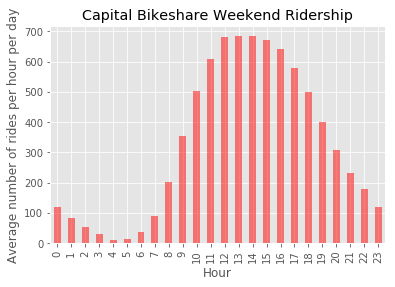

In [17]:
fig, ax = plt.subplots(figsize=[6, 4])
ax.set_ylabel('Average number of rides per hour per day')
ax.set_title('Capital Bikeshare Weekend Ridership')
(bikeshare_weekend.groupby('Hour')['Hour'].count() / weekend_days).plot(kind='bar',alpha=0.5, color='r', ax=ax)
plt.show()

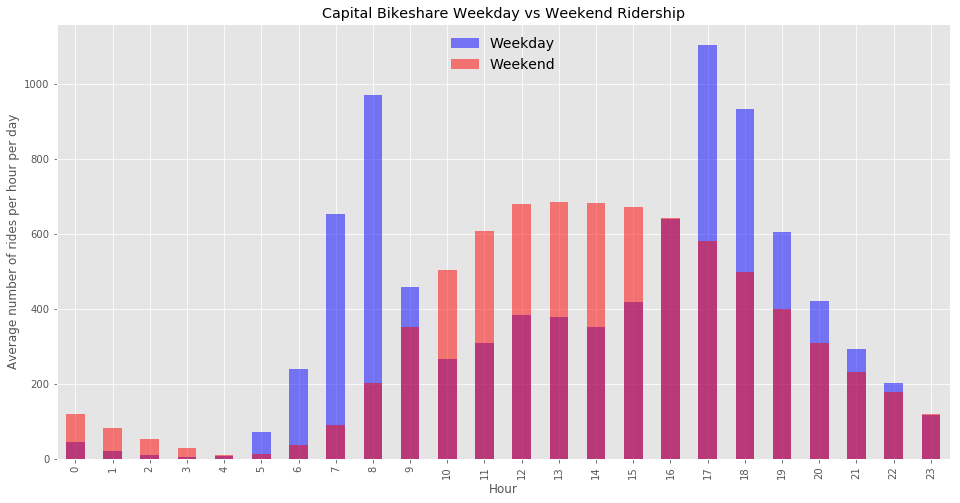

In [18]:
fig, ax = plt.subplots(figsize=[16, 8])
ax.set_ylabel('Average number of rides per hour per day')
ax.set_title('Capital Bikeshare Weekday vs Weekend Ridership')
(bikeshare_weekday.groupby('Hour')['Hour'].count() / len(business_days)).plot(kind='bar', alpha=0.5, color='b', 
                                                                              ax=ax,label= "Weekday")
(bikeshare_weekend.groupby('Hour')['Hour'].count() / weekend_days).plot(kind='bar',alpha=0.5, color='r', 
                                                                        ax=ax, label= "Weekend")
plt.legend(frameon=False, fontsize=14, loc=9)
plt.savefig('weekday_v_weekend.png', dpi=600)

A couple clear take aways, There are two spikes during the work week, one for each rush hour (centered on 8AM and 5PM), where as the weekend data just shows gradual changes with a max between 12:00 PM abd 3:00 PM  

What can we learn about 'Registered' vs 'Casual' riders during each of these time frames?  

(Capital Bikeshare groups their riders based on if they have a long term (registered; Annual Member, 30-Day Member or Day Key Member) or short term (casual; Single Trip, 24-Hour Pass, 3-Day Pass or 5-Day Pass) membership

In [19]:
bikeshare_weekday_casual = bikeshare_weekday[bikeshare_weekday['Member Type'] == 'Casual']
bikeshare_weekday_registered = bikeshare_weekday[bikeshare_weekday['Member Type'] == 'Registered']
bikeshare_weekend_casual = bikeshare_weekend[bikeshare_weekend['Member Type'] == 'Casual']
bikeshare_weekend_registered = bikeshare_weekend[bikeshare_weekend['Member Type'] == 'Registered']

In [20]:
print("Average rides of each type per day \n")
print('Weekday Casual: {}'.format(int(len(bikeshare_weekday_casual) / len(business_days))))
print('Weekday Registered: {}'.format(int(len(bikeshare_weekday_registered) / len(business_days))))
print('Weekend Casual: {}'.format(int(len(bikeshare_weekend_casual) / weekend_days)))
print('Weekend Registered: {}'.format(int(len(bikeshare_weekend_registered) / weekend_days)))

Average rides of each type per day 

Weekday Casual: 1316
Weekday Registered: 7589
Weekend Casual: 2707
Weekend Registered: 5078


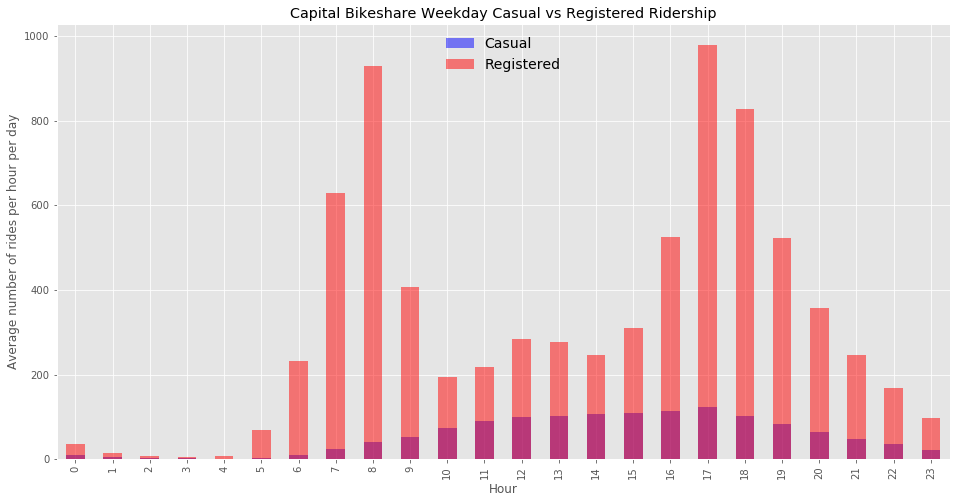

In [21]:
fig, ax = plt.subplots(figsize=[16, 8])
ax.set_ylabel('Average number of rides per hour per day')
ax.set_title('Capital Bikeshare Weekday Casual vs Registered Ridership')
(bikeshare_weekday_casual.groupby('Hour')['Hour'].count() / len(business_days)).plot(kind='bar', alpha=0.5, color='b', 
                                                                              ax=ax,label= "Casual")
(bikeshare_weekday_registered.groupby('Hour')['Hour'].count() / len(business_days)).plot(kind='bar',alpha=0.5, color='r', 
                                                                        ax=ax, label= "Registered")
plt.legend(frameon=False, fontsize=14, loc=9)
plt.savefig('weekday casual v registered.png', dpi=600)

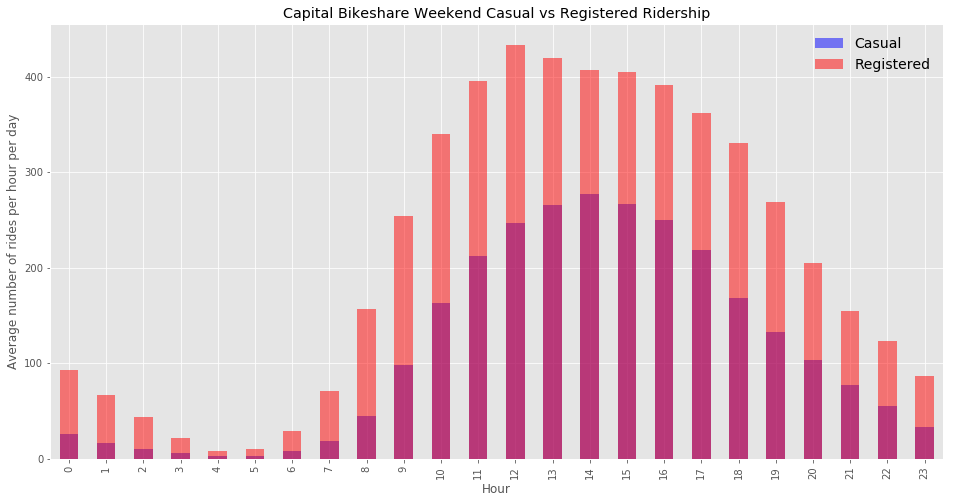

In [22]:
fig, ax = plt.subplots(figsize=[16, 8])
ax.set_ylabel('Average number of rides per hour per day')
ax.set_title('Capital Bikeshare Weekend Casual vs Registered Ridership')
(bikeshare_weekend_casual.groupby('Hour')['Hour'].count() / weekend_days).plot(kind='bar', alpha=0.5, color='b', 
                                                                              ax=ax,label= "Casual")
(bikeshare_weekend_registered.groupby('Hour')['Hour'].count() / weekend_days).plot(kind='bar',alpha=0.5, color='r', 
                                                                        ax=ax, label= "Registered")
plt.legend(frameon=False, fontsize=14, loc=1)

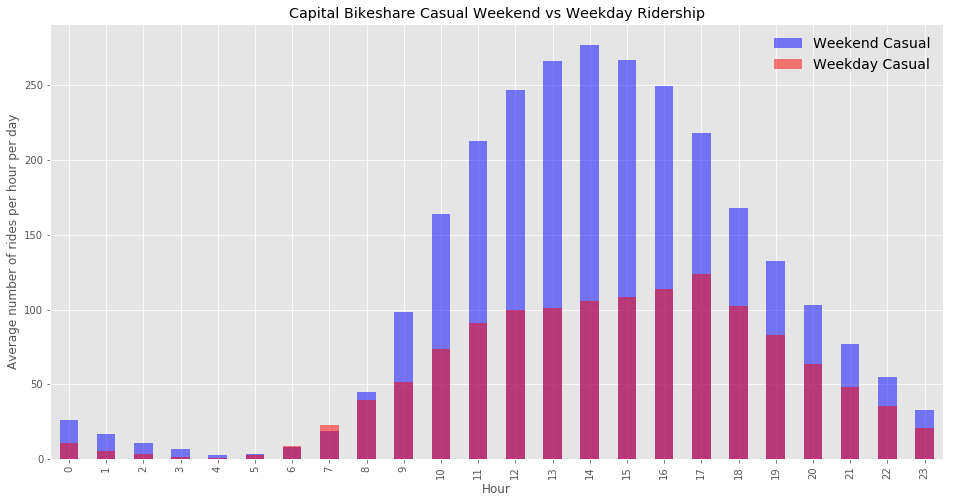

In [23]:
fig, ax = plt.subplots(figsize=[16, 8])
ax.set_ylabel('Average number of rides per hour per day')
ax.set_title('Capital Bikeshare Casual Weekend vs Weekday Ridership')
(bikeshare_weekend_casual.groupby('Hour')['Hour'].count() / weekend_days).plot(kind='bar', alpha=0.5, color='b', 
                                                                              ax=ax,label= "Weekend Casual")
(bikeshare_weekday_casual.groupby('Hour')['Hour'].count() / len(business_days)).plot(kind='bar',alpha=0.5, color='r', 
                                                                        ax=ax, label= "Weekday Casual")
plt.legend(frameon=False, fontsize=14, loc=1)

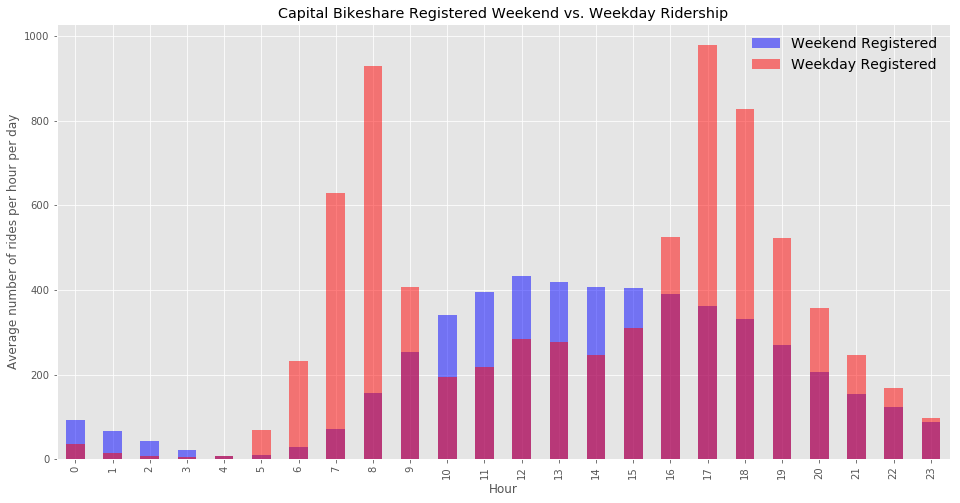

In [24]:
fig, ax = plt.subplots(figsize=[16, 8])
ax.set_ylabel('Average number of rides per hour per day')
ax.set_title('Capital Bikeshare Registered Weekend vs. Weekday Ridership')
(bikeshare_weekend_registered.groupby('Hour')['Hour'].count() / weekend_days).plot(kind='bar', alpha=0.5, color='b', 
                                                                              ax=ax,label= "Weekend Registered")
(bikeshare_weekday_registered.groupby('Hour')['Hour'].count() / len(business_days)).plot(kind='bar',alpha=0.5, color='r', 
                                                                        ax=ax, label= "Weekday Registered")
plt.legend(frameon=False, fontsize=14, loc=1)

Take aways:
* There are more registered than casual riders on both the weekends and weekdays. About 74% of all rides are during the work week and about 80% of all rides are from Registered users.
* during the work week, registered users clearly follow the 'rush hour' pattern, while the casual riders follow a more 'weekend' pattern. There does appear to be a slight jump in casual rides during the evening rush hour.
* on the weekends, the difference in pattern shape between registered and casual riders is minimal, only the volume of rides is significantly different.
* There are many more causal riders on the weekends than on weekdays (~ 2x), but they follow the same pattern shape during both windows.
* There are about 33% fewer registered weekend riders than weekday riders. This suggets that many of the registered riders are commuters who use the Capital Bikeshare system to get to work.

Now, lets slice up the data based on the rush hour patterns for registered used that we saw above.
* weekday morning rush hour (6:00 - 9:59 AM)
* weekday afternoon rush hour (4:00 - 7:59 PM)
* weekday non-rush hour

In [25]:
bikeshare_morning_rush = bikeshare_weekday_registered[(bikeshare_weekday_registered['Hour'] >= 6) & 
                                                      (bikeshare_weekday_registered['Hour'] <= 9)]
bikeshare_evening_rush = bikeshare_weekday_registered[(bikeshare_weekday_registered['Hour'] >= 16) & 
                                                      (bikeshare_weekday_registered['Hour'] <= 19)]
bikeshare_no_rush = bikeshare_weekday_registered[~((bikeshare_weekday_registered['Hour'] >= 16) & 
                                                   (bikeshare_weekday_registered['Hour'] <= 19)) & 
                                                 ~((bikeshare_weekday_registered['Hour'] >= 6) & 
                                                   (bikeshare_weekday_registered['Hour'] <= 9))]


In [26]:
print(bikeshare_morning_rush['Hour'].unique())
print(bikeshare_evening_rush['Hour'].unique())
print(bikeshare_no_rush['Hour'].unique())

[6 7 8 9]
[16 17 18 19]
[ 0  1  2  3  4  5 10 11 12 13 14 15 20 21 22 23]


#### Now, what can we learn about effect of the proximity of certain bike share stations to metro stations?

Create label for each trip indicating if it originated or concluded near a metro station (first determine which bike share stations are within 0.15 miles of a metro station)

In [27]:
bikeshare_morning_rush_close = bikeshare_morning_rush[bikeshare_morning_rush['Start station']
                                                      .str[:].isin(nearby_stations)]
bikeshare_morning_rush_far = bikeshare_morning_rush[~bikeshare_morning_rush['Start station']
                                                      .str[:].isin(nearby_stations)]
bikeshare_evening_rush_close = bikeshare_evening_rush[bikeshare_evening_rush['Start station']
                                                      .str[:].isin(nearby_stations)]
bikeshare_evening_rush_far = bikeshare_evening_rush[~bikeshare_evening_rush['Start station']
                                                      .str[:].isin(nearby_stations)]
bikeshare_no_rush_close = bikeshare_no_rush[bikeshare_no_rush['Start station']
                                            .str[:].isin(nearby_stations)]
bikeshare_no_rush_far = bikeshare_no_rush[~bikeshare_no_rush['Start station']
                                          .str[:].isin(nearby_stations)]

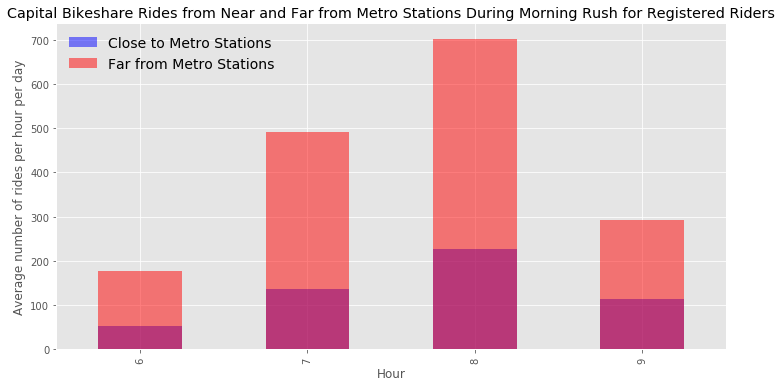

In [28]:
fig, ax = plt.subplots(figsize=[12, 6])
ax.set_ylabel('Average number of rides per hour per day')
ax.set_title('Capital Bikeshare Rides from Near and Far from Metro Stations During Morning Rush for Registered Riders')
(bikeshare_morning_rush_close.groupby('Hour')['Hour'].count() / len(business_days)).plot(kind='bar', alpha=0.5, color='b', 
                                                                              ax=ax,label= "Close to Metro Stations")
(bikeshare_morning_rush_far.groupby('Hour')['Hour'].count() / len(business_days)).plot(kind='bar',alpha=0.5, color='r', 
                                                                        ax=ax, label= "Far from Metro Stations")
plt.legend(frameon=False, fontsize=14, loc=2)

In [29]:
print('This is how many bike trips started from close to a metro station: {}'
      .format(str(len(bikeshare_morning_rush_close))))
print('This is how many bike trips started from far from a metro station: {}'
      .format(str(len(bikeshare_morning_rush_far))))
print('{:.2f}% of rides orginiated from {:.2f}% of stations'.format((len(bikeshare_morning_rush_close)/len(bikeshare_morning_rush)*100), 
                                                            (len(nearby_stations)/len(bike_location)*100)))

This is how many bike trips started from close to a metro station: 139917
This is how many bike trips started from far from a metro station: 436334
24.28% of rides orginiated from 19.50% of stations


The fact that 20% of bike stations (those within 0.15 miles of a metro station) account for ~ 25% of outgoing rides during the morning rush suggest that many commuters use the two transportation systems together.

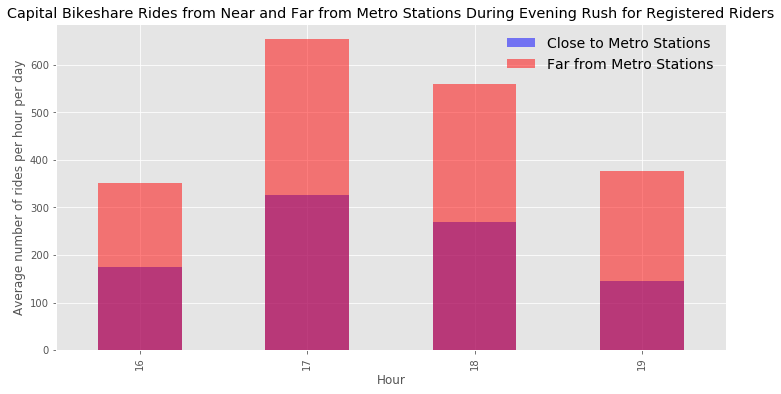

In [30]:
fig, ax = plt.subplots(figsize=[12, 6])
ax.set_ylabel('Average number of rides per hour per day')
ax.set_title('Capital Bikeshare Rides from Near and Far from Metro Stations During Evening Rush for Registered Riders')
(bikeshare_evening_rush_close.groupby('Hour')['Hour'].count() / len(business_days)).plot(kind='bar', alpha=0.5, color='b', 
                                                                              ax=ax,label= "Close to Metro Stations")
(bikeshare_evening_rush_far.groupby('Hour')['Hour'].count() / len(business_days)).plot(kind='bar',alpha=0.5, color='r', 
                                                                        ax=ax, label= "Far from Metro Stations")
plt.legend(frameon=False, fontsize=14, loc=1)

In [31]:
print('This is how many bike trips started from close to a metro station: {}'
      .format(str(len(bikeshare_evening_rush_close))))
print('This is how many bike trips started from far from a metro station: {}'
      .format(str(len(bikeshare_evening_rush_far))))
print('{:.2f}% of rides orginiated from {:.2f}% of stations'.format((len(bikeshare_evening_rush_close)/len(bikeshare_evening_rush)*100), 
                                                            (len(nearby_stations)/len(bike_location)*100)))

This is how many bike trips started from close to a metro station: 239829
This is how many bike trips started from far from a metro station: 508856
32.03% of rides orginiated from 19.50% of stations


#### Nearly 1/3 of all trips during the evening rush hour originate from within 0.15 miles of metro stations
Does this mean that people do indeed use bike share together with the metro? Perhaps they ride a bike to the metro in the morning, then metro to work. In the evening, they metro to near home, then bike the rest of the way.

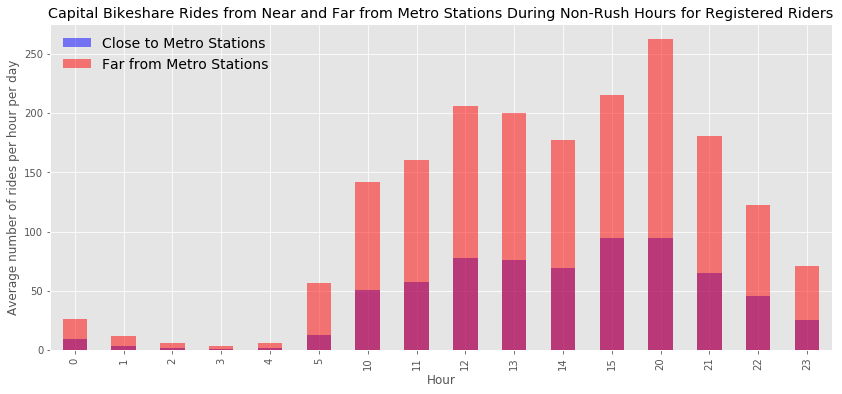

In [32]:
fig, ax = plt.subplots(figsize=[14, 6])
ax.set_ylabel('Average number of rides per hour per day')
ax.set_title('Capital Bikeshare Rides from Near and Far from Metro Stations During Non-Rush Hours for Registered Riders')
(bikeshare_no_rush_close.groupby('Hour')['Hour'].count() / len(business_days)).plot(kind='bar', alpha=0.5, color='b', 
                                                                              ax=ax,label= "Close to Metro Stations")
(bikeshare_no_rush_far.groupby('Hour')['Hour'].count() / len(business_days)).plot(kind='bar',alpha=0.5, color='r', 
                                                                        ax=ax, label= "Far from Metro Stations")
plt.legend(frameon=False, fontsize=14, loc=2)

In [33]:
print('This is how many bike trips started from close to a metro station: {}'
      .format(str(len(bikeshare_no_rush_close))))
print('This is how many bike trips started from far from a metro station: {}'
      .format(str(len(bikeshare_no_rush_far))))
print('{:.2f}% of rides orginiated from {:.2f}% of stations'.format((len(bikeshare_no_rush_close)/len(bikeshare_no_rush)*100), 
                                                            (len(nearby_stations)/len(bike_location)*100)))

This is how many bike trips started from close to a metro station: 179409
This is how many bike trips started from far from a metro station: 483987
27.04% of rides orginiated from 19.50% of stations


What about where bike share trips conclude?

In [34]:
bikeshare_morning_rush_close_end = bikeshare_morning_rush[bikeshare_morning_rush['End station']
                                                      .str[:].isin(nearby_stations)]
bikeshare_morning_rush_far_end = bikeshare_morning_rush[~bikeshare_morning_rush['End station']
                                                      .str[:].isin(nearby_stations)]
bikeshare_evening_rush_close_end = bikeshare_evening_rush[bikeshare_evening_rush['End station']
                                                      .str[:].isin(nearby_stations)]
bikeshare_evening_rush_far_end = bikeshare_evening_rush[~bikeshare_evening_rush['End station']
                                                      .str[:].isin(nearby_stations)]
bikeshare_no_rush_close_end = bikeshare_no_rush[bikeshare_no_rush['End station']
                                            .str[:].isin(nearby_stations)]
bikeshare_no_rush_far_end = bikeshare_no_rush[~bikeshare_no_rush['End station']
                                          .str[:].isin(nearby_stations)]

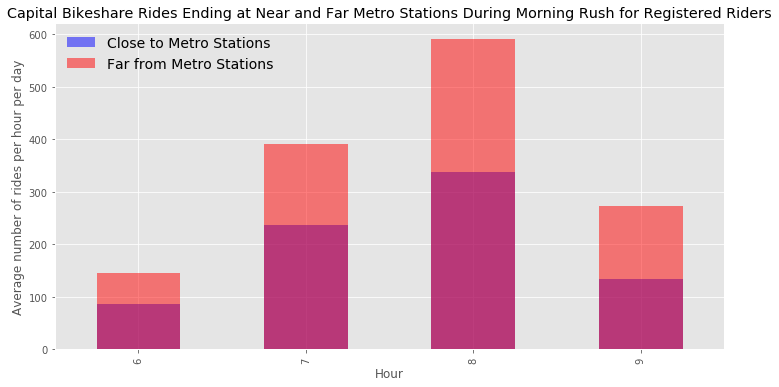

In [35]:
fig, ax = plt.subplots(figsize=[12, 6])
ax.set_ylabel('Average number of rides per hour per day')
ax.set_title('Capital Bikeshare Rides Ending at Near and Far Metro Stations During Morning Rush for Registered Riders')
(bikeshare_morning_rush_close_end.groupby('Hour')['Hour'].count() / len(business_days)).plot(kind='bar', alpha=0.5, color='b', 
                                                                              ax=ax,label= "Close to Metro Stations")
(bikeshare_morning_rush_far_end.groupby('Hour')['Hour'].count() / len(business_days)).plot(kind='bar',alpha=0.5, color='r', 
                                                                        ax=ax, label= "Far from Metro Stations")
plt.legend(frameon=False, fontsize=14, loc=2)

In [36]:
print('This is how many bike trips ended at a close metro station: {}'
      .format(str(len(bikeshare_morning_rush_close_end))))
print('This is how many bike trips ended at a far metro station: {}'
      .format(str(len(bikeshare_morning_rush_far_end))))
print('{:.2f}% of rides ending at {:.2f}% of stations'.format((len(bikeshare_morning_rush_close_end)/len(bikeshare_morning_rush)*100), 
                                                            (len(nearby_stations)/len(bike_location)*100)))

This is how many bike trips ended at a close metro station: 208771
This is how many bike trips ended at a far metro station: 367480
36.23% of rides ending at 19.50% of stations


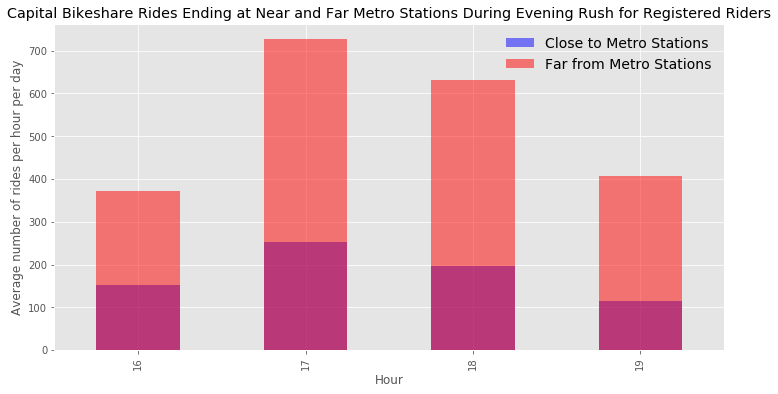

In [37]:
fig, ax = plt.subplots(figsize=[12, 6])
ax.set_ylabel('Average number of rides per hour per day')
ax.set_title('Capital Bikeshare Rides Ending at Near and Far Metro Stations During Evening Rush for Registered Riders')
(bikeshare_evening_rush_close_end.groupby('Hour')['Hour'].count() / len(business_days)).plot(kind='bar', alpha=0.5, color='b', 
                                                                              ax=ax,label= "Close to Metro Stations")
(bikeshare_evening_rush_far_end.groupby('Hour')['Hour'].count() / len(business_days)).plot(kind='bar',alpha=0.5, color='r', 
                                                                        ax=ax, label= "Far from Metro Stations")
plt.legend(frameon=False, fontsize=14, loc=1)

In [38]:
print('This is how many bike trips ended at a close metro station: {}'
      .format(str(len(bikeshare_evening_rush_close_end))))
print('This is how many bike trips ended at a far metro station: {}'
      .format(str(len(bikeshare_evening_rush_far_end))))
print('{:.2f}% of rides ending at {:.2f}% of stations'.format((len(bikeshare_evening_rush_close_end)/len(bikeshare_evening_rush)*100), 
                                                            (len(nearby_stations)/len(bike_location)*100)))

This is how many bike trips ended at a close metro station: 188184
This is how many bike trips ended at a far metro station: 560501
25.14% of rides ending at 19.50% of stations


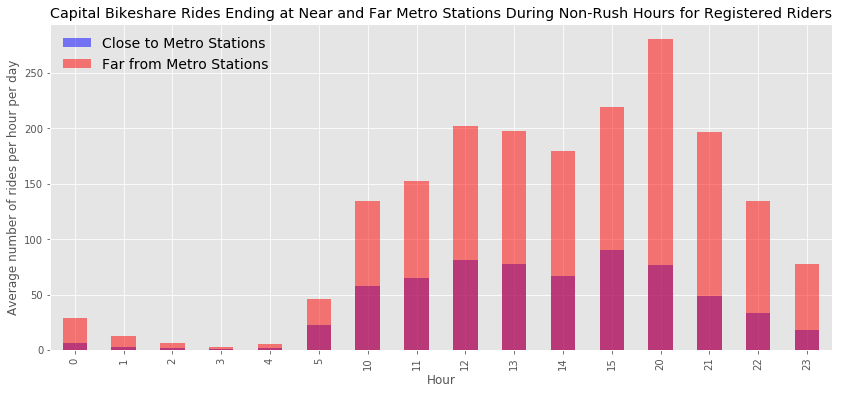

In [39]:
fig, ax = plt.subplots(figsize=[14, 6])
ax.set_ylabel('Average number of rides per hour per day')
ax.set_title('Capital Bikeshare Rides Ending at Near and Far Metro Stations During Non-Rush Hours for Registered Riders')
(bikeshare_no_rush_close_end.groupby('Hour')['Hour'].count() / len(business_days)).plot(kind='bar', alpha=0.5, color='b', 
                                                                              ax=ax,label= "Close to Metro Stations")
(bikeshare_no_rush_far_end.groupby('Hour')['Hour'].count() / len(business_days)).plot(kind='bar',alpha=0.5, color='r', 
                                                                        ax=ax, label= "Far from Metro Stations")
plt.legend(frameon=False, fontsize=14, loc=2)

In [40]:
print('This is how many bike trips ended close to a metro station: {}'
      .format(str(len(bikeshare_no_rush_close))))
print('This is how many bike trips ended far from a metro station: {}'
      .format(str(len(bikeshare_no_rush_far))))
print('{:.2f}% of rides ending at {:.2f}% of stations'.format((len(bikeshare_no_rush_close_end)/len(bikeshare_no_rush)*100), 
                                                            (len(nearby_stations)/len(bike_location)*100)))

This is how many bike trips ended close to a metro station: 179409
This is how many bike trips ended far from a metro station: 483987
25.81% of rides ending at 19.50% of stations


#### Now what can we learn from considering the distances of these trips?

In [41]:
def route_dist(x, y):
    """ this will return the distance between two point using the vincenty method
    This method is meant to be 'applied' to a dataframe"""
    start = bike_location[x]
    end = bike_location[y]
    return vincenty(start, end).miles

In [42]:
# this step is very slow - it would have been better to make a list of all unique routes, 
# then calculate their distance only once. Next time...
bikeshare_morning_rush['Ride dist'] = bikeshare_morning_rush.apply(lambda x: route_dist(x['Start station'], x['End station']),
                                                                   axis=1)

/Users/DDT1-Old/anaconda/lib/python3.6/site-packages/ipykernel/__main__.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [43]:
bikeshare_morning_rush['Ride dist'].describe()

count    576251.000000
mean          1.263647
std           0.817990
min           0.000000
25%           0.654141
50%           1.068510
75%           1.677147
max          12.773643
Name: Ride dist, dtype: float64

In [44]:
bikeshare_evening_rush['Ride dist'] = bikeshare_evening_rush.apply(lambda x: route_dist(x['Start station'], x['End station']),
                                                                   axis=1)

/Users/DDT1-Old/anaconda/lib/python3.6/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app


In [45]:
bikeshare_evening_rush['Ride dist'].describe()

count    748685.000000
mean          1.157711
std           0.774916
min           0.000000
25%           0.591867
50%           0.970354
75%           1.522205
max          13.526540
Name: Ride dist, dtype: float64

In [46]:
bikeshare_no_rush['Ride dist'] = bikeshare_no_rush.apply(lambda x: route_dist(x['Start station'], x['End station']),
                                                                   axis=1)

/Users/DDT1-Old/anaconda/lib/python3.6/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app


In [47]:
bikeshare_no_rush['Ride dist'].describe()

count    663396.000000
mean          1.023776
std           0.712535
min           0.000000
25%           0.531176
50%           0.846326
75%           1.344000
max          13.526540
Name: Ride dist, dtype: float64

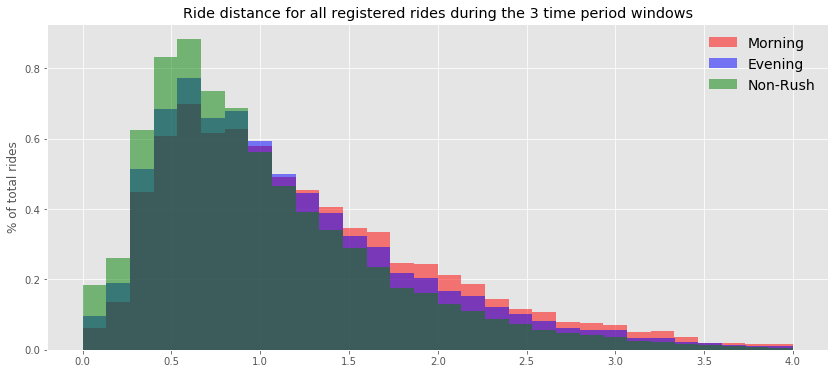

In [48]:
fig, ax = plt.subplots(figsize=[14, 6])
(bikeshare_morning_rush[bikeshare_morning_rush['Ride dist'] < 4]['Ride dist']).plot.hist(bins=30, alpha=0.5, normed = True,
                                                                                         ax=ax, color='r', label='Morning')
(bikeshare_evening_rush[bikeshare_evening_rush['Ride dist'] < 4]['Ride dist']).plot.hist(bins=30, alpha=0.5, normed = True,
                                                                                         ax=ax, color='b', label='Evening')
(bikeshare_no_rush[bikeshare_no_rush['Ride dist'] < 4]['Ride dist']).plot.hist(bins=30, alpha=0.5, normed = True,
                                                                               ax=ax, color='g', label='Non-Rush')
ax.set_ylabel('% of total rides')
ax.set_title('Ride distance for all registered rides during the 3 time period windows')
plt.legend(frameon=False, fontsize=14, loc=1)

While rides appear to get slightly shorter throughout the day, there is not a strong dependence.  
What about those near and far from a metro station?

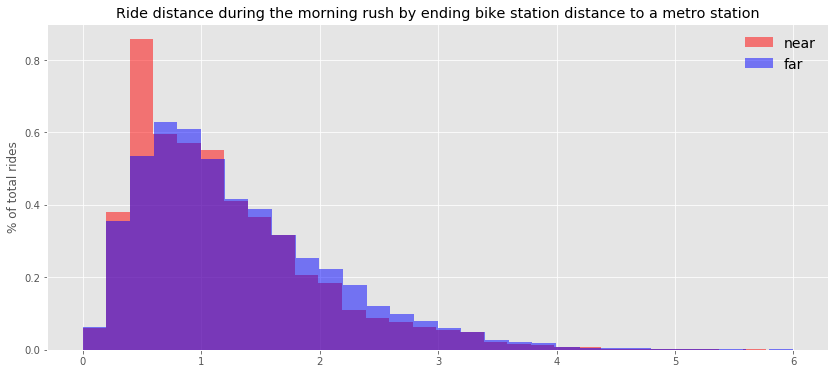

In [49]:
fig, ax = plt.subplots(figsize=[14, 6])
temp1 = bikeshare_morning_rush.groupby('End dist').get_group('near')
temp1[temp1['Ride dist']< 6]['Ride dist'].plot.hist(bins=30, alpha=0.5, normed=True,
                                                                                         ax=ax, color='r', label='near')
temp2 = bikeshare_morning_rush.groupby('End dist').get_group('far')
temp2[temp2['Ride dist']< 6]['Ride dist'].plot.hist(bins=30, alpha=0.5, normed=True,
                                                                                         ax=ax, color='b', label='far')

#(bikeshare_morning_rush[bikeshare_morning_rush['Ride dist'] < 4]['Ride dist']).plot.hist(bins=30, alpha=0.5,
#                                                                                         ax=ax, color='r', label='Morning')
plt.legend(frameon=False, fontsize=14, loc=1)
ax.set_ylabel('% of total rides')
ax.set_title('Ride distance during the morning rush by ending bike station distance to a metro station')
plt.savefig('ride distance morning rush.png', dpi=600)

There is a spike in the distances around 0.5 miles for morning rides that end at stations near metro stations. This spike is also present in evening rides beginning at near metro stations.

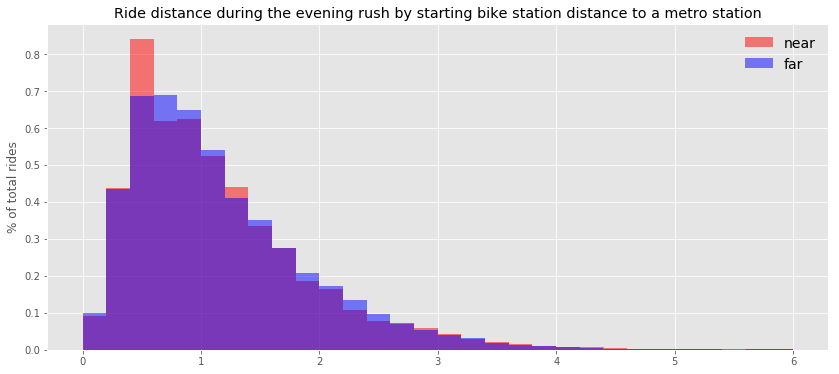

In [50]:
fig, ax = plt.subplots(figsize=[14, 6])
temp1 = bikeshare_evening_rush.groupby('Start dist').get_group('near')
temp1[temp1['Ride dist']< 6]['Ride dist'].plot.hist(bins=30, alpha=0.5, normed=True,
                                                                                         ax=ax, color='r', label='near')
temp2 = bikeshare_evening_rush.groupby('Start dist').get_group('far')
temp2[temp2['Ride dist']< 6]['Ride dist'].plot.hist(bins=30, alpha=0.5, normed=True,
                                                                                         ax=ax, color='b', label='far')

#(bikeshare_morning_rush[bikeshare_morning_rush['Ride dist'] < 4]['Ride dist']).plot.hist(bins=30, alpha=0.5,
#                                                                                         ax=ax, color='r', label='Morning')
plt.legend(frameon=False, fontsize=14, loc=1)
ax.set_ylabel('% of total rides')
ax.set_title('Ride distance during the evening rush by starting bike station distance to a metro station')
plt.savefig('ride distance evening rush.png', dpi=600)

This suggests that there are a significant number of commuters who use the bike share to travel about 0.5 miles to near metro stations in the morning, and away from metro stations in the evening

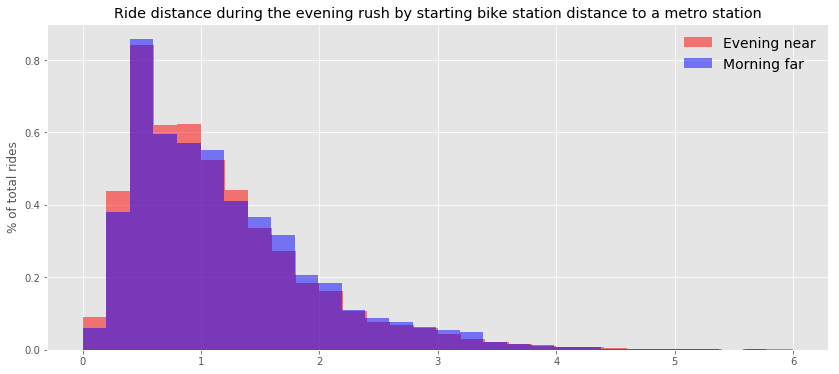

In [51]:
fig, ax = plt.subplots(figsize=[14, 6])
temp1 = bikeshare_evening_rush.groupby('Start dist').get_group('near')
temp1[temp1['Ride dist']< 6]['Ride dist'].plot.hist(bins=30, alpha=0.5, normed=True,
                                                                                         ax=ax, color='r', label='Evening near')
temp2 = bikeshare_morning_rush.groupby('End dist').get_group('near')
temp2[temp2['Ride dist']< 6]['Ride dist'].plot.hist(bins=30, alpha=0.5, normed=True,
                                                                                         ax=ax, color='b', label='Morning far')

#(bikeshare_morning_rush[bikeshare_morning_rush['Ride dist'] < 4]['Ride dist']).plot.hist(bins=30, alpha=0.5,
#                                                                                         ax=ax, color='r', label='Morning')
plt.legend(frameon=False, fontsize=14, loc=1)
ax.set_ylabel('% of total rides')
ax.set_title('Ride distance during the evening rush by starting bike station distance to a metro station')
plt.savefig('ride distance morning v evening rush.png', dpi=600)

In [52]:
bikeshare_morning_rush['Ride dist'].quantile(0.50)

1.068509725450834

In [53]:
bikeshare_morning_rush['Ride dist'].describe()

count    576251.000000
mean          1.263647
std           0.817990
min           0.000000
25%           0.654141
50%           1.068510
75%           1.677147
max          12.773643
Name: Ride dist, dtype: float64

In [54]:
bikeshare_weekday_casual['Ride dist'] = bikeshare_weekday_casual.apply(lambda x: route_dist(x['Start station'], x['End station']),
                                                                axis=1)

/Users/DDT1-Old/anaconda/lib/python3.6/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app


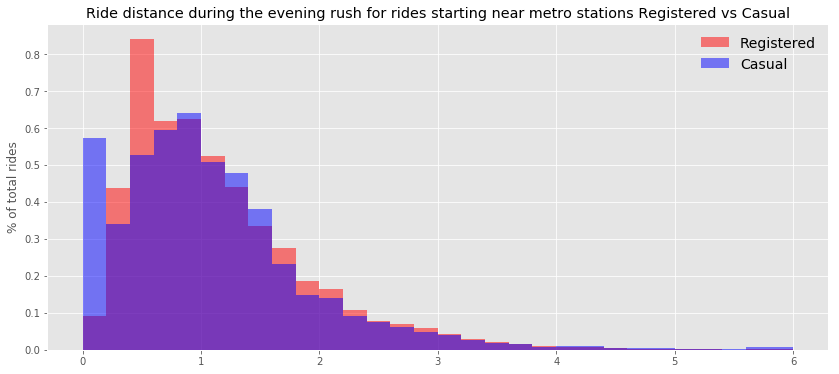

In [55]:
fig, ax = plt.subplots(figsize=[14, 6])
temp1 = bikeshare_evening_rush.groupby('Start dist').get_group('near')
temp1[temp1['Ride dist']< 6]['Ride dist'].plot.hist(bins=30, alpha=0.5, normed=True,
                                                                                         ax=ax, color='r', label='Registered')
temp2 = bikeshare_weekday_casual.groupby('Start dist').get_group('near')
temp2[temp2['Ride dist']< 6]['Ride dist'].plot.hist(bins=30, alpha=0.5, normed=True,
                                                                                         ax=ax, color='b', label='Casual')

#(bikeshare_morning_rush[bikeshare_morning_rush['Ride dist'] < 4]['Ride dist']).plot.hist(bins=30, alpha=0.5,
#                                                                                         ax=ax, color='r', label='Morning')
plt.legend(frameon=False, fontsize=14, loc=1)
ax.set_ylabel('% of total rides')
ax.set_title('Ride distance during the evening rush for rides starting near metro stations Registered vs Casual')
plt.savefig('ride distance evening casual v registered rush.png', dpi=600)

The above plot compares the distance traveled for registered and casual riders departing from bike share station hours near metro stations during the evening rush.  
The spike at < 0.2 miles is likely people starting and ending in the same bike share stations

#### Now lets compare the popularity of the different bike share stations and routes during the different time windows  
The below lists are of the 10 most popular bike share stations during each time frame

In [56]:
bikeshare_morning_rush.groupby('End station')['End station'].count().sort_values(ascending=False)[:10]

End station
Columbus Circle / Union Station         20137
13th St & New York Ave NW               13221
Massachusetts Ave & Dupont Circle NW    12212
Thomas Circle                           10558
17th & K St NW / Farragut Square         9984
21st & I St NW                           9130
North Capitol St & F St NW               8643
17th & K St NW                           8474
17th & Rhode Island Ave NW               7549
Metro Center / 12th & G St NW            7220
Name: End station, dtype: int64

In [57]:
bikeshare_morning_rush.groupby('Start station')['Start station'].count().sort_values(ascending=False)[:10]

Start station
Columbus Circle / Union Station              21517
Thomas Circle                                10291
New Hampshire Ave & T St NW                   7582
Massachusetts Ave & Dupont Circle NW          7532
14th & V St NW                                7098
16th & Harvard St NW                          6581
5th St & Massachusetts Ave NW                 6552
15th & P St NW                                6374
Lincoln Park / 13th & East Capitol St NE      6176
5th & K St NW                                 6048
Name: Start station, dtype: int64

In [58]:
bikeshare_morning_rush.groupby('Route')['Route'].count().sort_values(ascending=False)[:10]

Route
8th & F St NE to Columbus Circle / Union Station                                                    1783
11th & H St NE to Columbus Circle / Union Station                                                   1684
Columbus Circle / Union Station to M St & New Jersey Ave SE                                         1526
13th & D St NE to Columbus Circle / Union Station                                                   1497
Columbus Circle / Union Station to USDA / 12th & Independence Ave SW                                1464
Carroll & Ethan Allen Ave to Takoma Metro                                                           1341
Lincoln Park / 13th & East Capitol St NE  to Eastern Market Metro / Pennsylvania Ave & 7th St SE    1320
Columbus Circle / Union Station to 4th & E St SW                                                    1294
D St & Maryland Ave NE to Columbus Circle / Union Station                                           1291
15th & F St NE to Columbus Circle / Union Station

In [59]:
bikeshare_evening_rush.groupby('Start station')['Start station'].count().sort_values(ascending=False)[:10]

Start station
Columbus Circle / Union Station                        21133
Massachusetts Ave & Dupont Circle NW                   13348
15th & P St NW                                          9157
Thomas Circle                                           9056
Eastern Market Metro / Pennsylvania Ave & 7th St SE     8719
North Capitol St & F St NW                              8547
17th & K St NW                                          8248
17th & K St NW / Farragut Square                        8201
Metro Center / 12th & G St NW                           8023
5th & K St NW                                           7477
Name: Start station, dtype: int64

In [60]:
bikeshare_evening_rush.groupby('End station')['End station'].count().sort_values(ascending=False)[:10]

End station
Columbus Circle / Union Station         20123
15th & P St NW                          12553
Massachusetts Ave & Dupont Circle NW    12001
14th & V St NW                          11723
New Hampshire Ave & T St NW             11170
5th & K St NW                           10063
14th & Rhode Island Ave NW               8749
17th & Corcoran St NW                    8308
14th & R St NW                           7945
8th & O St NW                            7791
Name: End station, dtype: int64

In [61]:
bikeshare_evening_rush.groupby('Route')['Route'].count().sort_values(ascending=False)[:10]

Route
Columbus Circle / Union Station to 8th & F St NE                                                    2456
Columbus Circle / Union Station to 11th & H St NE                                                   1499
Eastern Market Metro / Pennsylvania Ave & 7th St SE to Lincoln Park / 13th & East Capitol St NE     1427
Columbus Circle / Union Station to 6th & H St NE                                                    1265
Columbus Circle / Union Station to 13th & H St NE                                                   1255
Columbus Circle / Union Station to 13th & D St NE                                                   1220
Columbus Circle / Union Station to 15th & F St NE                                                   1195
L'Enfant Plaza / 7th & C St SW to Columbus Circle / Union Station                                   1112
Eastern Market Metro / Pennsylvania Ave & 7th St SE to 13th & D St NE                               1083
USDA / 12th & Independence Ave SW to Columbus Cir

In [62]:
(bikeshare_evening_rush.groupby('Start dist').get_group('near')
 .groupby('Route')['Route'].count().sort_values(ascending=False)[:10])

Route
Columbus Circle / Union Station to 8th & F St NE                                                    2456
Columbus Circle / Union Station to 11th & H St NE                                                   1499
Eastern Market Metro / Pennsylvania Ave & 7th St SE to Lincoln Park / 13th & East Capitol St NE     1427
Columbus Circle / Union Station to 6th & H St NE                                                    1265
Columbus Circle / Union Station to 13th & H St NE                                                   1255
Columbus Circle / Union Station to 13th & D St NE                                                   1220
Columbus Circle / Union Station to 15th & F St NE                                                   1195
L'Enfant Plaza / 7th & C St SW to Columbus Circle / Union Station                                   1112
Eastern Market Metro / Pennsylvania Ave & 7th St SE to 13th & D St NE                               1083
USDA / 12th & Independence Ave SW to Columbus Cir

**ALL of the top 10 most popular routes during the evening rush hour originating from bike stations close to the metro**

In [63]:
bikeshare_no_rush.groupby('End station')['End station'].count().sort_values(ascending=False)[:10]

End station
Columbus Circle / Union Station         15645
Massachusetts Ave & Dupont Circle NW    12971
15th & P St NW                          12578
14th & V St NW                           9949
New Hampshire Ave & T St NW              8783
17th & Corcoran St NW                    8361
5th & K St NW                            8301
Thomas Circle                            7964
14th & R St NW                           7442
8th & H St NW                            7371
Name: End station, dtype: int64

In [64]:
bikeshare_no_rush.groupby('Start station')['Start station'].count().sort_values(ascending=False)[:10]

Start station
Massachusetts Ave & Dupont Circle NW                   12967
Columbus Circle / Union Station                        11694
15th & P St NW                                         11288
14th & V St NW                                          8666
Thomas Circle                                           8268
New Hampshire Ave & T St NW                             8085
17th & Corcoran St NW                                   8022
Eastern Market Metro / Pennsylvania Ave & 7th St SE     7691
8th & H St NW                                           7659
14th & R St NW                                          7110
Name: Start station, dtype: int64

In [65]:
bikeshare_weekday_casual.groupby('Start station')['Start station'].count().sort_values(ascending=False)[:10]

Start station
Lincoln Memorial                                    25509
Jefferson Dr & 14th St SW                           23795
Jefferson Memorial                                  11183
Maryland & Independence Ave SW                       8375
Constitution Ave & 2nd St NW/DOL                     7450
New York Ave & 15th St NW                            7290
Henry Bacon Dr & Lincoln Memorial Circle NW          6435
Ohio Dr & West Basin Dr SW / MLK & FDR Memorials     6398
Massachusetts Ave & Dupont Circle NW                 5529
10th St & Constitution Ave NW                        4958
Name: Start station, dtype: int64

In [66]:
(bikeshare_weekday_casual.groupby('Route')['Route'].count().sort_values(ascending=False)[:10])

Route
Jefferson Dr & 14th St SW to Jefferson Dr & 14th St SW                                                  4007
Jefferson Dr & 14th St SW to Lincoln Memorial                                                           3650
Lincoln Memorial to Jefferson Memorial                                                                  3243
Lincoln Memorial to Jefferson Dr & 14th St SW                                                           3036
Lincoln Memorial to Lincoln Memorial                                                                    2712
Jefferson Memorial to Lincoln Memorial                                                                  1696
Ohio Dr & West Basin Dr SW / MLK & FDR Memorials to Ohio Dr & West Basin Dr SW / MLK & FDR Memorials    1595
Jefferson Memorial to Jefferson Dr & 14th St SW                                                         1328
Jefferson Dr & 14th St SW to Jefferson Memorial                                                         1311
Lincoln Memor

A quick review of the above lists suggests a couple of things.
1. the most popular routes in the morning by far are form NE to the Union Station metro
2. the most popular routes in the evening are from Union Station metro to NE

Lets try a T-test of the evening rush hour data to see if there is a statistical significance

In [67]:
near = (bikeshare_evening_rush.groupby('Start dist').get_group('near')
 .groupby('Start station')['Start station'].count() / len(nearby_stations))
far = (bikeshare_evening_rush.groupby('Start dist').get_group('far')
 .groupby('Start station')['Start station'].count()/ (len(bikeshare_rides['Start station'].unique()) - len(nearby_stations)))

print(scipy.stats.ttest_ind(far, near, equal_var=False))
print(scipy.stats.ttest_ind(near, far, equal_var=True))
print("\nMood's median test\n")
print(scipy.stats.median_test(near, far))
print('\n', near.describe(), '\n')
print(far.describe())

Ttest_indResult(statistic=-6.9100742734354084, pvalue=1.1118718959462095e-09)
Ttest_indResult(statistic=13.425447957286158, pvalue=3.2760000243636039e-34)

Mood's median test

(45.883700097370983, 1.2548573310008007e-11, 3.0691823899371071, array([[ 67, 135],
       [ 12, 190]]))

 count     79.000000
mean      35.300118
std       38.952652
min        0.232558
25%        6.627907
50%       26.918605
75%       49.627907
max      245.732558
Name: Start station, dtype: float64 

count    325.000000
mean       4.923619
std        6.196233
min        0.003145
25%        0.493711
50%        1.968553
75%        7.405660
max       28.795597
Name: Start station, dtype: float64


In [68]:
near = (bikeshare_evening_rush.groupby('Start dist').get_group('near')
 .groupby('Start station')['Start station'].count() / len(nearby_stations))
far = (bikeshare_morning_rush.groupby('Start dist').get_group('near')
 .groupby('Start station')['Start station'].count()/ len(nearby_stations))

print(scipy.stats.ttest_ind(far, near, equal_var=False))
print(scipy.stats.ttest_ind(near, far, equal_var=True))
print("\nMood's median test\n")
print(scipy.stats.median_test(near, far))
print('\n', near.describe(), '\n')
print(far.describe())

Ttest_indResult(statistic=-2.5709256675226775, pvalue=0.011106429407308695)
Ttest_indResult(statistic=2.5709256675226775, pvalue=0.011077607286486662)

Mood's median test

(8.2025316455696196, 0.0041831979315147304, 13.581395348837209, array([[49, 30],
       [30, 49]]))

 count     79.000000
mean      35.300118
std       38.952652
min        0.232558
25%        6.627907
50%       26.918605
75%       49.627907
max      245.732558
Name: Start station, dtype: float64 

count     79.000000
mean      20.594201
std       32.672965
min        0.011628
25%        3.238372
50%        9.686047
75%       26.005814
max      250.197674
Name: Start station, dtype: float64


#### Now let's make maps highlighting some of our key findings

In [69]:
def line_map_all_near(metro = station_data, bikestations = nearby_stations):
    map_osm = folium.Map(location=[38.889931, -77.009003], tiles='Stamen Toner',
           zoom_start=13)
    for key1 in metro:
        for key in metro[key1]:
            folium.Marker(metro[key1][key], popup= key, 
                          icon=folium.Icon(color='green')).add_to(map_osm)
    for ii in range(len(bikestations)):
        folium.Marker(bike_location[bikestations[ii]], popup= bikestations[ii], 
                      icon=folium.Icon(color='red')).add_to(map_osm)
    return map_osm

def line_map_all(metro = station_data, bikestations = nearby_stations, bike_loc = bike_location):
    map_osm = folium.Map(location=[38.889931, -77.009003], tiles='Stamen Toner',
           zoom_start=13)
    for key1 in metro:
        for key in metro[key1]:
            folium.Marker(metro[key1][key], popup= key, 
                          icon=folium.Icon(color='green')).add_to(map_osm)
    for key in bike_loc:
        if key in bikestations:
            folium.Marker(bike_loc[key], popup= key, 
                      icon=folium.Icon(color='red')).add_to(map_osm)
        else:
            folium.Marker(bike_loc[key], popup= key, 
                      icon=folium.Icon(color='blue')).add_to(map_osm)
    return map_osm



In [70]:
near_map = line_map_all_near()
near_map.save('metro_nearbikes_map.html')
near_map

In [71]:
map_all_stations = line_map_all()
map_all_stations.save('all_stations_map.html')
map_all_stations

In [72]:
bikeshare_morning_rush.groupby(by='Route')['Route'].count().sort_values(ascending=False).index.str.split('\sto')[:10]

Index([                                                ['8th & F St NE', ' Columbus Circle / Union Station'],
                                                      ['11th & H St NE', ' Columbus Circle / Union Station'],
                                            ['Columbus Circle / Union Station', ' M St & New Jersey Ave SE'],
                                                      ['13th & D St NE', ' Columbus Circle / Union Station'],
                                   ['Columbus Circle / Union Station', ' USDA / 12th & Independence Ave SW'],
                                                              ['Carroll & Ethan Allen Ave', ' Takoma Metro'],
       ['Lincoln Park / 13th & East Capitol St NE ', ' Eastern Market Metro / Pennsylvania Ave & 7th St SE'],
                                                       ['Columbus Circle / Union Station', ' 4th & E St SW'],
                                              ['D St & Maryland Ave NE', ' Columbus Circle / Union Station'],
          

In [73]:
def line_map_popular(metro = station_data, bikestations = nearby_stations, bike_loc = bike_location):
    map_osm = folium.Map(location=[38.889931, -77.009003], tiles='Stamen Toner',
           zoom_start=13)
    for key1 in metro:
        for key in metro[key1]:
            folium.Marker(metro[key1][key], popup= key, 
                          icon=folium.Icon(color='green')).add_to(map_osm)
    for ii in range(len(bikestations)):
        folium.Marker(bike_loc[bikestations[ii][0]], popup= bikestations[ii][0], 
                      icon=folium.Icon(color='red')).add_to(map_osm)
        folium.Marker(bike_loc[bikestations[ii][1]], popup= bikestations[ii][1], 
                      icon=folium.Icon(color='blue')).add_to(map_osm)
    return map_osm

In [74]:
morning_10_map = line_map_popular(bikestations = bikeshare_morning_rush.groupby(by='Route')['Route'].count()
                 .sort_values(ascending=False).index.str.split('\sto\s')[:10])
morning_10_map.save('morning_10_map.html')
morning_10_map

In [75]:
evening_10_map = line_map_popular(bikestations = bikeshare_evening_rush.groupby(by='Route')['Route'].count()
                 .sort_values(ascending=False).index.str.split('\sto\s')[:10])
evening_10_map.save('evening_10_map.html')
evening_10_map

In [76]:
(bikeshare_evening_rush.groupby(by='Route')['Route'].count()
                 .sort_values(ascending=False).index.str.split('\sto')[:10])

Index([                                                ['Columbus Circle / Union Station', ' 8th & F St NE'],
                                                      ['Columbus Circle / Union Station', ' 11th & H St NE'],
       ['Eastern Market Metro / Pennsylvania Ave & 7th St SE', ' Lincoln Park / 13th & East Capitol St NE '],
                                                       ['Columbus Circle / Union Station', ' 6th & H St NE'],
                                                      ['Columbus Circle / Union Station', ' 13th & H St NE'],
                                                      ['Columbus Circle / Union Station', ' 13th & D St NE'],
                                                      ['Columbus Circle / Union Station', ' 15th & F St NE'],
                                      ['L'Enfant Plaza / 7th & C St SW', ' Columbus Circle / Union Station'],
                                  ['Eastern Market Metro / Pennsylvania Ave & 7th St SE', ' 13th & D St NE'],
          

In [77]:
casual_10_map = line_map_popular(bikestations = bikeshare_weekday_casual.groupby(by='Route')['Route'].count()
                 .sort_values(ascending=False).index.str.split('\sto\s')[:10])
casual_10_map.save('casual_10_map.html')
casual_10_map